# AutoMM for Semantic Segmentation - Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/image_segmentation/beginner_semantic_seg.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/image_prediction/beginner_semantic_seg.ipynb)


Semantic Segmentation is a computer vision task in which the goal is to produce a dense pixel-wise segmentation map of an image, where each pixel is assigned to a specific class or object. It is used to recognize a collection of pixels that form distinct categories. For example, an autonomous vehicle needs to identify vehicles, pedestrians, traffic signs, pavement, and other road features.

Segment Anything Model (SAM) is a foundation model that was pretrained on large-scale segmentation data with 1B masks and 11M images. Despite its excellent zero-shot performance on generic scenes, it faces challenges to generalize to specialized domain, such as remote sensing, medical imagery, agriculture, and manufacturing. Fortunately, AutoMM can help bridge the domain gap by finetuning SAM on domain-specific data.

In this quick start, we'll show how to use AutoMM to finetune SAM. Once the paths of images and corresponding groundtruth masks are prepared in [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) format, a single call to `fit()` will take care of the model training for you.


## Prepare Data

For demonstration purposes, we use the [Leaf Disease Segmentation](https://www.kaggle.com/datasets/sovitrath/leaf-disease-segmentation-with-trainvalid-split) from Kaggle. Automatic disease detection is necessary to speed up the process of plant pathology. Segmenting a specific region on a leaf or plant can be extremely challenging. Particularly, when the diseased region is not so large. There can be several types of diseases that can affect the leaves of a plant. Some diseases cover a larger area and some a very small area.

To get started, let’s download and prepare the dataset.

In [ ]:
!pip install autogluon.multimodal


In [1]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/semantic_segmentation/leaf_disease_segmentation.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

Then we can load the CSV files.

In [2]:
import pandas as pd
import os
dataset_path = os.path.join(download_dir, 'leaf_disease_segmentation')
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
val_data = pd.read_csv(f'{dataset_path}/val.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
image_col = 'image'
label_col = 'label'

The relative paths need to be expanded so that data loading can work correctly in training/test.

In [3]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

for per_col in [image_col, label_col]:
    train_data[per_col] = train_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    val_data[per_col] = val_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    test_data[per_col] = test_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    

print(train_data[image_col].iloc[0])
print(train_data[label_col].iloc[0])

/home/ubuntu/projects/autogluon/docs/tutorials/multimodal/image_segmentation/ag_automm_tutorial/leaf_disease_segmentation/train_images/00002.jpg
/home/ubuntu/projects/autogluon/docs/tutorials/multimodal/image_segmentation/ag_automm_tutorial/leaf_disease_segmentation/train_masks/00002.png


Each dataframe has two columns with the paths of images and corresponding groundtruth masks, respectively. Let's take a look at the dataframe of training data.

In [4]:
train_data.head()

,image,label
0,/home/ubuntu/projects/autogluon/docs/tutorials...,/home/ubuntu/projects/autogluon/docs/tutorials...
1,/home/ubuntu/projects/autogluon/docs/tutorials...,/home/ubuntu/projects/autogluon/docs/tutorials...
2,/home/ubuntu/projects/autogluon/docs/tutorials...,/home/ubuntu/projects/autogluon/docs/tutorials...
3,/home/ubuntu/projects/autogluon/docs/tutorials...,/home/ubuntu/projects/autogluon/docs/tutorials...
4,/home/ubuntu/projects/autogluon/docs/tutorials...,/home/ubuntu/projects/autogluon/docs/tutorials...


We can also visualize the one image and its groundtruth mask.

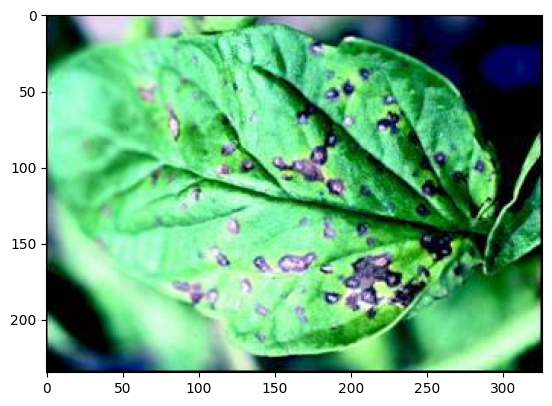

In [5]:
from autogluon.multimodal.utils.semantic_segmentation_visualizer import SegmentationVisualizer
visualizer = SegmentationVisualizer()
visualizer.plot_image(test_data.iloc[0]['image'])

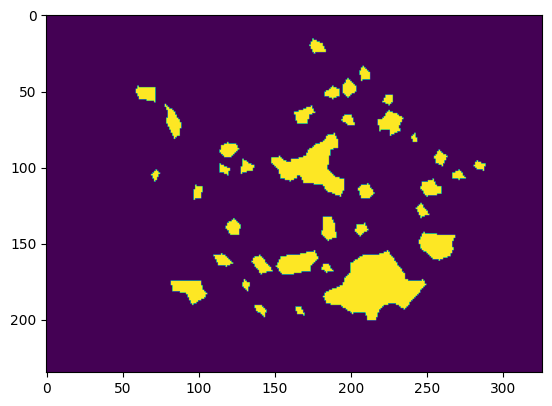

In [6]:
visualizer.plot_image(test_data.iloc[0]['label'])

## Zero Shot Evaluation

First, let's see how well pretrained SAM can segment it. Here we choose the base SAM model for a quick demo.

In [7]:
from autogluon.multimodal import MultiModalPredictor
predictor_zero_shot = MultiModalPredictor(
    problem_type="semantic_segmentation", 
    label=label_col,
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
)

After the predictor is initialized, we can directly do inference.

In [11]:
predictor_zero_shot._learner._label_column = None
pred_zero_shot = predictor_zero_shot.predict({'image': [test_data.iloc[0]['image']]})

Predicting: 0it [00:00, ?it/s]

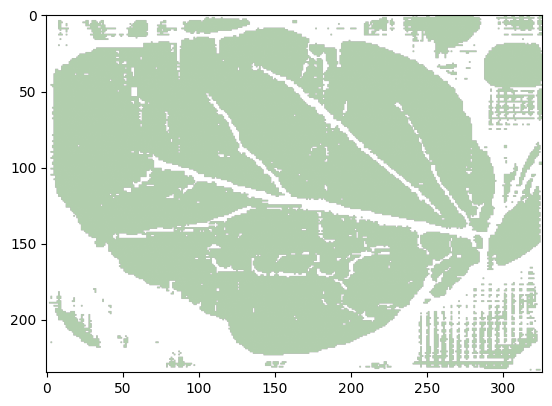

In [12]:
visualizer.plot_mask(pred_zero_shot)

We can see that SAM without prompts outputs the rough leaf mask instead of the disease masks. It's normal because SAM has no context about the domain task. Though SAM can perform better with proper click prompts, it is not an end-to-end solution due to the reliance on extra prompt inputs. Some applications may require one standalone model for deployment in practice.

We can also do zero-shot evalution on the test data.

In [13]:
predictor_zero_shot._learner._label_column = label_col
scores = predictor_zero_shot.evaluate(test_data, metrics=["iou"])
print(scores)

Predicting: 0it [00:00, ?it/s]

{'iou': 0.14003166556358337}


As expected, the test score of zero-shot SAM is low. Next, let's see how to finetune SAM for better performance.

## Finetune SAM

We can initialize a new predictor and fit it with the training and validation data.

In [14]:
from autogluon.multimodal import MultiModalPredictor
import uuid
save_path = f"./tmp/{uuid.uuid4().hex}-automm_semantic_seg"
predictor = MultiModalPredictor(
    problem_type="semantic_segmentation", 
    label="label",
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
    path=save_path,
)
predictor.fit(
    train_data=train_data,
    tuning_data=val_data,
    time_limit=180, # seconds
)

INFO: Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.3b20231027.

- Pytorch version is 2.0.1+cu117.

- Model will be saved to "/home/ubuntu/projects/autogluon/docs/tutorials/multimodal/image_segmentation/tmp/909ffb891626408daeae58f4c6f389e3-automm_semantic_seg".

- Validation metric is "iou".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /home/ubuntu/projects/autogluon/docs/tutorials/multimodal/image_segmentation/tmp/909ffb891626408daeae58f4c6f389e3-automm_semantic_seg
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai

/home/ubuntu/projects/autogluon/multimodal/src/autogluon/multimodal/utils/config.py:551: UserWarning: Received loss function=structure_loss for problem=semantic_segmentation. Currently, we only support using BCE loss for regression problems and choose the loss_function au

Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/ag-dev/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: 0it [00:00, ?it/s]

INFO: Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 98: 'val_iou' reached 0.56439 (best 0.56439), saving model to '/home/ubuntu/projects/autogluon/docs/tutorials/multimodal/image_segmentation/tmp/909ffb891626408daeae58f4c6f389e3-automm_semantic_seg/epoch=0-step=98.ckpt' as top 3
AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/home/ubuntu/projects/autogluon/docs/tutorials/multimodal/image_segmentation/tmp/909ffb891626408daeae58f4c6f389e3-automm_semantic_seg")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /home/ubuntu/projects/autogluon/docs/tutorials/multimodal/image_segmentation/tmp/909ffb891626408daeae58f4c6f389e3-automm_semantic_seg
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters 

You can evaluate the finetuned SAM on the test data.

In [16]:
scores = predictor.evaluate(test_data, metrics=["iou"])
print(scores)

Predicting: 0it [00:00, ?it/s]

{'iou': 0.5885318517684937}


Thanks to the finetuning, the test score has improved substantially.

Given the above sample image, let's visualize the predicted mask after finetuning.

In [19]:
pred = predictor.predict({'image': [test_data.iloc[0]['image']]})

Predicting: 0it [00:00, ?it/s]

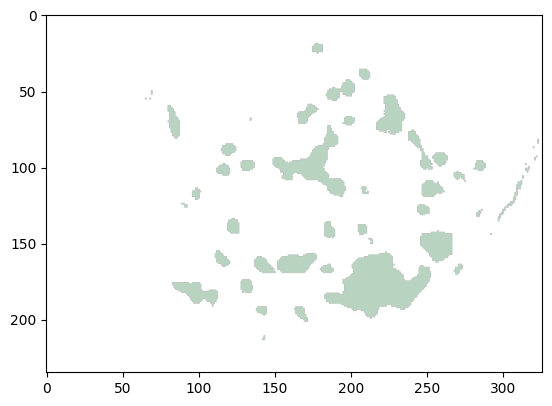

In [20]:
visualizer.plot_mask(pred)

As you can see, the predicted mask is much closer to the groundtruth now.

## Save and Load

The trained predictor is automatically saved at the end of `fit()`, and you can easily reload it.

```{warning}

`MultiModalPredictor.load()` uses `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

```

In [21]:
loaded_predictor = MultiModalPredictor.load(save_path)
scores = loaded_predictor.evaluate(test_data, metrics=["iou"])
print(scores)

Load pretrained checkpoint: /home/ubuntu/projects/autogluon/docs/tutorials/multimodal/image_segmentation/tmp/909ffb891626408daeae58f4c6f389e3-automm_semantic_seg/model.ckpt


Predicting: 0it [00:00, ?it/s]

{'iou': 0.5885318517684937}


We can see the evaluation score is still the same as above, which means same model!

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).